In [144]:
from numpy import *
from pylab import *
%matplotlib inline
%run "funciones_a_llamar.ipynb"

In [145]:
def e_mov(r_v,t,fric=0, g=9.8,m=1):
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0:
        dvx,dvy = 0,-g
    else:
        dvx = - fric([r_v[2],r_v[3]])[0]/m
        dvy = -g- fric([r_v[2],r_v[3]])[1]/m
    return array([dx,dy,dvx,dvy])

In [146]:
def fric_v(v,gamma=0.1):
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y]) 

In [147]:
def rot_vel(ang):
    ang = ang*pi/180.
    return array([1,0,0,0]),array([0,1,0,0]),array([0,0,cos(ang),-sin(ang)]),array([0,0,sin(ang),cos(ang)])

In [148]:
def piso(x,angulo):
    return tan(angulo*pi/180.)*abs(x)

def plano(x,angulo):
    return -tan(angulo*pi/180.)*x

def techo(x,angulo):
    y = zeros(len(x))
    a = 5*tan(angulo*pi/180.)
    y[:] = a + 3
    return y

In [149]:
def rebote(r_v_i,mi_dt,ang,modelo_fric=0):
    dt_busqueda = mi_dt/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],modelo_fric)
    y_med = sol[-1,:]

    while abs(y_izq[1]-plano(y_izq[0],ang))>1e-5:
        if (y_izq[1]-plano(y_izq[0],ang))*(y_med[1]-plano(y_med[0],ang))<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t, sol = rk4(e_mov, reinicio,[0,dt_busqueda],modelo_fric)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = dot(rot_vel(ang),y_izq)
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq

In [204]:
def rebote_techo(r_v_i,mi_dt,ang,modelo_fric=0):
    dt_busqueda = mi_dt/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],modelo_fric)
    y_med = sol[-1,:]
    tope_y = 3 + 5*tan(angulo*pi/180.)

    while abs(y_izq[1]-tope_y)>1e-5:
        if (y_izq[1]-tope_y)*(y_med[1]-tope_y)<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t, sol = rk4(e_mov, reinicio,[0,dt_busqueda],modelo_fric)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = dot(rot_vel(ang),y_izq)
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq

In [238]:
def rebote_pared(r_v_i,mi_dt,modelo_fric=0):
    dt_busqueda = mi_dt/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],modelo_fric)
    y_med = sol[-1,:]
    pared = sign(y_izq[0])*5

    while abs(y_izq[0]-pared)>1e-5:
        if (y_izq[0]-pared)*(y_med[0]-pared)<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t, sol = rk4(e_mov, reinicio,[0,dt_busqueda],modelo_fric)
        y_izq = reinicio
        y_med = sol[-1,:]
        pared = sign(y_izq[0])*5
    y_izq = array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
    return y_izq

In [239]:
def datos_graf(cond_ini, ang, modelo_fric=0,pts=100, dt=0.1):
    N = pts
    inicio = cond_ini
    trayectoria = zeros((N,len(inicio)))
    mi_dt = dt
    trayectoria[0,:] = array(inicio)
    tope_y = 3 + 5*tan(angulo*pi/180.)
    
    
    for i in range(N-1):
        t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt], modelo_fric)
    
        if sol_dt[-1,:][0]<=0 and sol_dt[-1,:][1]-plano(sol_dt[-1,:][0], ang) < 0:
            y_izq = rebote(trayectoria[i,:],mi_dt,ang)    
            trayectoria[i+1,:] = y_izq
        elif sol_dt[-1,:][0] > 0 and sol_dt[-1,:][1]-plano(sol_dt[-1,:][0], -ang) < 0:
            y_izq = rebote(trayectoria[i,:],mi_dt,-ang)    
            trayectoria[i+1,:] = y_izq
        elif sol_dt[-1,:][1] >= tope_y:
            y_izq = rebote_techo(trayectoria[i,:],mi_dt,0)    
            trayectoria[i+1,:] = y_izq
        elif 5 <= abs(sol_dt[-1,:][0]):
            y_izq = rebote_pared(trayectoria[i,:],mi_dt,0)    
            trayectoria[i+1,:] = y_izq
        else:
            trayectoria[i+1,:] = sol_dt[-1,:]
    return trayectoria

In [240]:
modelos = [0 , fric_v,]
etiquetas = ['Sin friccion','Proporcinal a V']

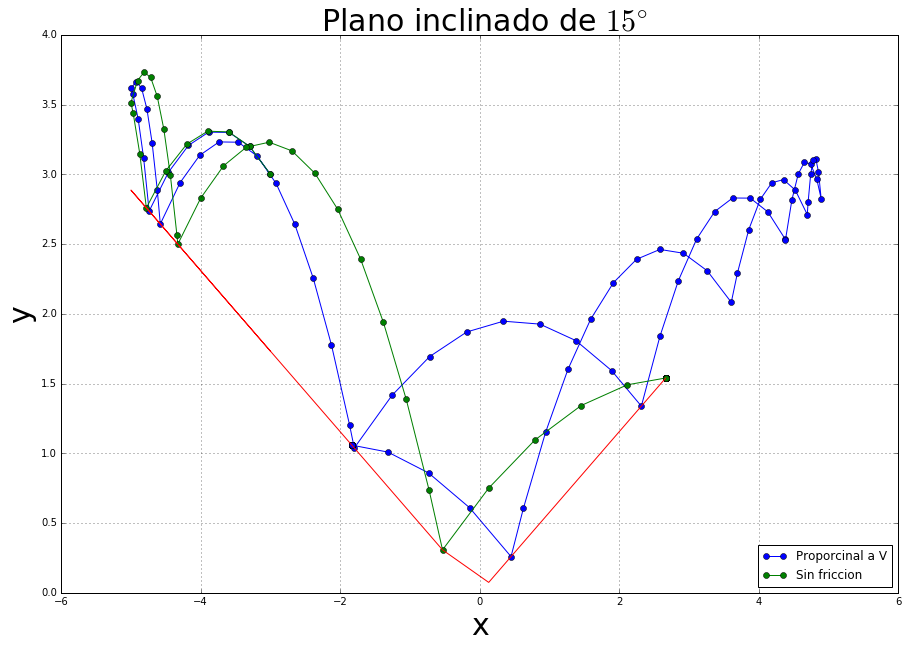

In [241]:
inicio = [-3,3, -3,2.5 ]
angulo = 30

fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $15^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

for i in xrange(len(modelos)):
    trayectoria = datos_graf(inicio,angulo,modelos[1-i])
    plot(trayectoria[:,0],trayectoria[:,1],'o-', label = str(etiquetas[1-i]))
plot(trayectoria[:,0],-plano(abs(trayectoria[:,0]),angulo))
ax.legend(loc='lower right')
show()

In [197]:
techo([1],15)

array([ 4.33974596])